TODO:


Currently:
- Article is about caching as opposed to persisting in general
- Show how to view memory usage due to cache
- Show some analysis where caching is appropriate
- Touch on execution plan and catalyst optimiser
- Summary and tips on when to cache and when not to cache

Proposed structure:
- Article is about persisting
- Mention execution plan and catalyst optimiser (link to dedicated article?)
- Discussion on persisting strategy
- Link to caching article
- Link to dedicated article on checkpointing/staging tables



- persisting strategy and mention execution plan and cat optimiser
- checkpointing and staging tables
- caching


# Persisting in Spark

Persisting Spark DataFrames is done to improve efficiency. There are two different cases where persisting can be useful:

1. Lineage of the DataFrame is long and complex
2. Stop unnecessary repetitions of processes

In this article we discuss the different methods of persisting data with Spark, their advantages and disadvantages.

## Lineage, execution plan and the catalyst optimiser

Before we discuss persistance we should discuss lineage, the execution plan and the catalyst optimiser.

We know that Spark uses lazy evaluation, meaning it doesn't process data until it has to e.g. infering the schema of a file, a row count, returning some data using `.show()`/`head() %>% collect()` or writing data to disk. As we execute DataFrame transformations Spark tracks the lineage of the DataFrame and creates an execution plan. When we execute an action Spark executes the plan. This is quite different to how regular Python, pandas or R works. Why does Spark work in this way?  Because Spark will find more efficient ways to process the data than just following our commands one after the other, and when it comes to processing big data, this is really useful. 

The way Spark optimises our jobs is using the [catalyst optimiser](https://databricks.com/glossary/catalyst-optimizer) and the [tungsten optimiser](https://databricks.com/glossary/tungsten). The former uses a list of rules to change our code into a more efficient strategy, whereas the latter performs optimisations on the hardware.

## Breaking DataFrame lineage

As we apply more transformations to our DataFrames the lineage grows and so does the execution plan. If the lineage is long and complex Spark will struggle to optimise the plan and take a long time to process the DataFrame. 

Let's say we are executing an interative algorithm on a DataFrame, for example we apply some calculation to a column to create a new column and use this new column as the input to the calculation in the next iteration. We notice that Spark struggles to execute the code after 10 iterations. What we can do to solve this issue is every 5 iterations we write the DataFrame out to disk and read it back in for the next iteration. Writing the data out to disk is a form of [persistance](https://en.wikipedia.org/wiki/Persistence_(computer_science)). Persistance is used in Spark to break the lineage of a DataFrame. 

## 

# How big is my data?

One of the main uses of persistence in Spark is to find out how much memory is used to store data. This is a tricky subject because the amount of memory or disk space a data set uses depends on:

1. whether the data are on disk (in storage) or in memory (being used)
2. format (e.g. csv or parquet on disk, Pandas or Spark DataFrame in memory)
3. data types
4. serialisation (compression)

...and so on...

Most of the list above is beyond the scope of this notebook, but with the necessary caveats in place let's give it a go...

As usual we'll start with some imports and creating a `SparkSession` object

In [32]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [33]:
spark = (
    SparkSession.builder.appName("persist")
    .config("spark.executor.memory", "1g")
    .config("spark.executor.cores", 1)
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.dynamicAllocation.maxExecutors", 2)
    .config("spark.shuffle.service.enabled", "true")
    .config("spark.ui.showConsoleProgress", "false")
    .enableHiveSupport()
    .getOrCreate()
)

Next we need some data. Here we're using a very small table of synthetic data, mainly because this notebook might be used on the DevTest cluster, which is a small cluster and so can't handle large data sets. It's not a good idea to `.cache()` a large DataFame in this environment.

In [34]:
import os
username = os.getenv("HADOOP_USER_NAME")
data_path = f"/user/{username}/more_spark"

In [35]:
people = spark.read.parquet(data_path + "/people.parquet")

In [36]:
people.cache().count()

5000

### For R users

<span style="color:blue">Cache a table by name using the line below,</span>

`tbl_cache(sc, "people", force=TRUE)` ,

<span style="color:blue">where `sc` is the `spark_connect()` object. The `force=TRUE` argument is the action so no need to pipe this into a `count()`. Also note that the name of the DataFrame will appear in the Spark UI, which is a nice feature and isn't the case in PySpark.</span>

Note that `.cache()` is a transformation, so to initiate moving the data into memory we need an action, hence the `.count()` above.

Now we can take a look in the Spark UI. In the next cell is some code that will generate a link to the Spark UI using some environment variables. Open the link in a new tab.

In [37]:
import os, IPython
url = "spark-%s.%s" % (os.environ["CDSW_ENGINE_ID"], os.environ["CDSW_DOMAIN"])
IPython.display.HTML("<a href=http://%s>Spark UI</a>" % url)

Within the Spark UI, head over to the *Storage* tab and you will see an RDD stored in memory, in two partitions and using 65.1 kB of executor memory.

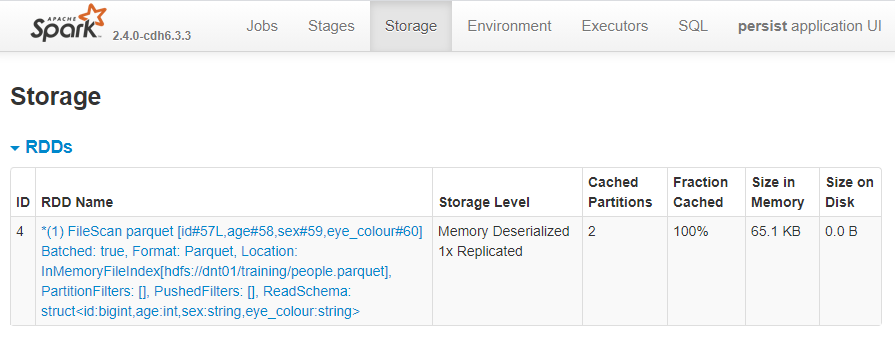

You can also click on the RDD name to get more information, such as how many executors are being used and the size of each partition.

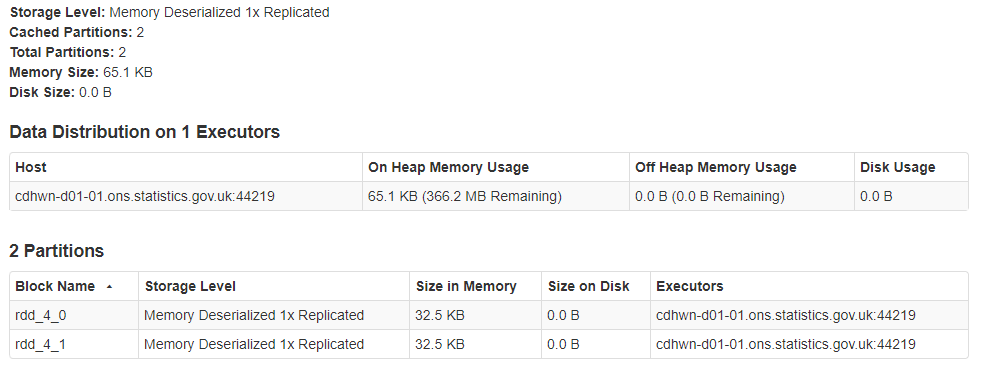

## `.persist` or `.cache`?

`.persist()` is a general form of `.cache()`. It is the same as calling `.cache()` where we are able to specify where to store the data, e.g. use memory but allow spill over to disk if the executor memory is full. The `.persist()` method takes a `StorageLevel` argument to specify where to cache the data. Options for storage levels are:  

`MEMORY_ONLY`

`MEMORY_AND_DISK`  

`MEMORY_ONLY_SER`   

`MEMORY_AND_DISK_SER`   

`DISK_ONLY`  

`OFF_HEAP`   

Using the `MEMORY_ONLY` option is equivalent to `.cache()`. More information on  storage levels can be found in the [Apache Spark documentation](https://spark.apache.org/docs/2.4.0/rdd-programming-guide.html#rdd-persistence)

There's an example below to see how this is used, first we will unpersist the previous `.cache()`

In [38]:
people.unpersist()

DataFrame[id: bigint, age: int, sex: string, eye_colour: string]

In [39]:
from pyspark import StorageLevel
people.persist(StorageLevel.DISK_ONLY).count()

5000

Before we move on, head back to the Spark UI and have a look at how much space the `people` DataFrame uses on disk.

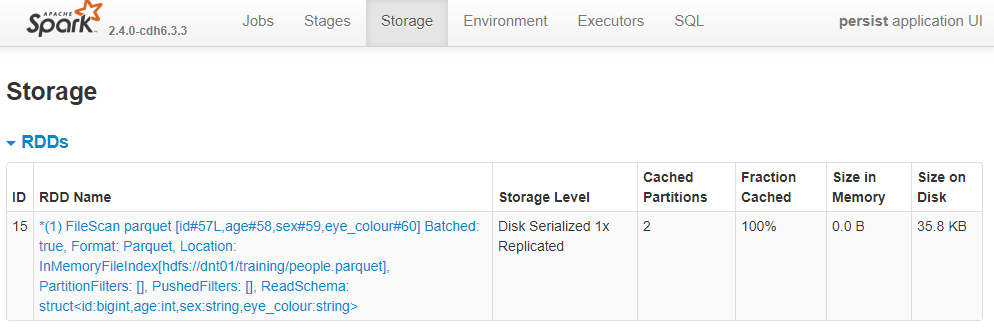

Is this what you expected? Why is this number different?

[Databricks](https://en.wikipedia.org/wiki/Databricks), a company founded by the creators of Apache Spark, suggest not bothering with `.persist()`. The are cases where you might want to `cache()`, write to disk or `.checkpoint()` (see exercises), but `.persist()` is not as efficient as these options. 

In [40]:
people.unpersist()

DataFrame[id: bigint, age: int, sex: string, eye_colour: string]

### For R users

<span style="color:blue">The syntax to remove tables by name from memory is,</span>
    
`tbl_uncache(sc, "people")`

<span style="color:blue">And to persist data using different storage options you can use,</span>
    
`sdf_persist(people, storage.level = "DISK_ONLY") %>% count()`

<span style="color:blue">Note you will need to pipe this into a `count()`</span>


# Using `.cache` for more efficient coding

Let's take a look at using `.cache()` to speed up our processing. The scenario is that we want to read in some data and apply some cleaning and preprocessing. Then using this *clean* DataFrame we want to produce three tables as outputs for a publication.

The data we will use are the animal rescue data set collected by the London Fire Brigade.

## Preparing the data

In [41]:
rescue = spark.read.csv(
    data_path + "/animal_rescue.csv", 
    header=True, inferSchema=True, 
)

The DataFrame is read into a single partition, which is fine because it's a small amount of data. However, we'll repartition to later demonstrate a feature of Spark.

In [42]:
rescue = rescue.repartition(2)

In [43]:
rescue = rescue.drop(
    'WardCode', 
    'BoroughCode', 
    'Easting_m', 
    'Northing_m', 
    'Easting_rounded', 
    'Northing_rounded'
)

In [44]:
rescue = (rescue
          .withColumnRenamed("PumpCount", "EngineCount")
          .withColumnRenamed("FinalDescription", "Description")
          .withColumnRenamed("HourlyNotionalCost(£)", "HourlyCost")
          .withColumnRenamed("IncidentNotionalCost(£)", "TotalCost")
          .withColumnRenamed("OriginofCall", "OriginOfCall")
          .withColumnRenamed("PumpHoursTotal", "JobHours")
          .withColumnRenamed("AnimalGroupParent", "AnimalGroup")
)

In [45]:
rescue = rescue.withColumn(
    "DateTimeOfCall", F.to_date(rescue.DateTimeOfCall, "dd/MM/yyyy")
)

In [46]:
rescue = rescue.withColumn(
    "IncidentDuration", 
    rescue.JobHours / rescue.EngineCount
)

In [47]:
rescue = rescue.na.drop(subset=["TotalCost", "IncidentDuration"])

Note that the above cells executed very quickly. Why? They're all **transformations**! Spark hasn't executed the code yet, take a look at the Spark UI if you're not convinced. So far Spark has created an execution plan but is waiting for an **action** to implement the plan.

## Analysis

Now we have our cleaned DataFrame we can go on to produce some tables for our article on animal rescue costs for the London Fire Brigade. Here we will put the code into functions because we will rerun these snippets of code multiple times in this notebook.

In [48]:
def get_top_10_incidents(rescue):
    return (
        rescue
        .select("CalYear", "PostcodeDistrict", "AnimalGroup", "IncidentDuration", "TotalCost")
        .sort("TotalCost", ascending=False)
        .limit(10)
    )

In [49]:
def get_mean_cost_by_animal(rescue):
    return (
        rescue
        .groupBy("AnimalGroup")
        .agg(F.mean("TotalCost").alias('MeanCost'))
        .sort("MeanCost", ascending=False)
        .limit(10)
    )

In [50]:
def get_summary_cost_by_animal(rescue):
    return (
        rescue.filter(
            rescue.AnimalGroup.isin(
                "Goat", 
                "Bull", 
                "Fish", 
                "Horse"
            ))
        .groupBy("AnimalGroup")
        .agg(
            F.min('TotalCost').alias('Min'), 
            F.avg('TotalCost').alias('Mean'), 
            F.max('TotalCost').alias('Max'), 
            F.count('TotalCost').alias('Count'))
        .sort("Mean", ascending=False)
    )

Next we will call the above functions and show the results

In [51]:
top_10_incidents = get_top_10_incidents(rescue)
top_10_incidents.show(truncate=False)

+-------+----------------+---------------------+----------------+---------+
|CalYear|PostcodeDistrict|AnimalGroup          |IncidentDuration|TotalCost|
+-------+----------------+---------------------+----------------+---------+
|2016   |NW5             |Cat                  |4.0             |3912.0   |
|2013   |E4              |Horse                |6.0             |3480.0   |
|2015   |TN14            |Horse                |5.0             |2980.0   |
|2018   |UB4             |Horse                |4.0             |2664.0   |
|2014   |TW4             |Cat                  |4.5             |2655.0   |
|2011   |E17             |Horse                |3.0             |2340.0   |
|2011   |E14             |Deer                 |3.0             |2340.0   |
|2011   |E17             |Horse                |3.0             |2340.0   |
|2018   |TN16            |Unknown - Wild Animal|3.5             |2296.0   |
|2017   |N19             |Cat                  |3.5             |2282.0   |
+-------+---

In [52]:
mean_cost_by_animal = get_mean_cost_by_animal(rescue)
mean_cost_by_animal.show(truncate=False)

+------------------------------------------------+------------------+
|AnimalGroup                                     |MeanCost          |
+------------------------------------------------+------------------+
|Goat                                            |1180.0            |
|Bull                                            |780.0             |
|Fish                                            |780.0             |
|Horse                                           |747.4350649350649 |
|Unknown - Animal rescue from water - Farm animal|709.6666666666666 |
|Cow                                             |624.1666666666666 |
|Hedgehog                                        |520.0             |
|Lamb                                            |520.0             |
|Deer                                            |423.8829787234043 |
|Unknown - Wild Animal                           |390.03636363636366|
+------------------------------------------------+------------------+



In [53]:
summary_cost_by_animal = get_summary_cost_by_animal(rescue)
summary_cost_by_animal.show()

+-----------+------+-----------------+------+-----+
|AnimalGroup|   Min|             Mean|   Max|Count|
+-----------+------+-----------------+------+-----+
|       Goat|1180.0|           1180.0|1180.0|    1|
|       Fish| 260.0|            780.0|1300.0|    2|
|       Bull| 780.0|            780.0| 780.0|    1|
|      Horse| 255.0|747.4350649350649|3480.0|  154|
+-----------+------+-----------------+------+-----+



Great- we have our tables. Let's take a look at the individual steps Spark carried out to create our outputs.

## Investigate the Spark UI

Go into the Spark UI and look at the *SQL* tab which lists the queries that are created from our PySpark code. Alternatively, we could use the *Jobs* tab, but the *SQL* tab has more detailed information for our needs here. 

Click on the query with a description that starts with 'csv' and look at the DAG diagram. 

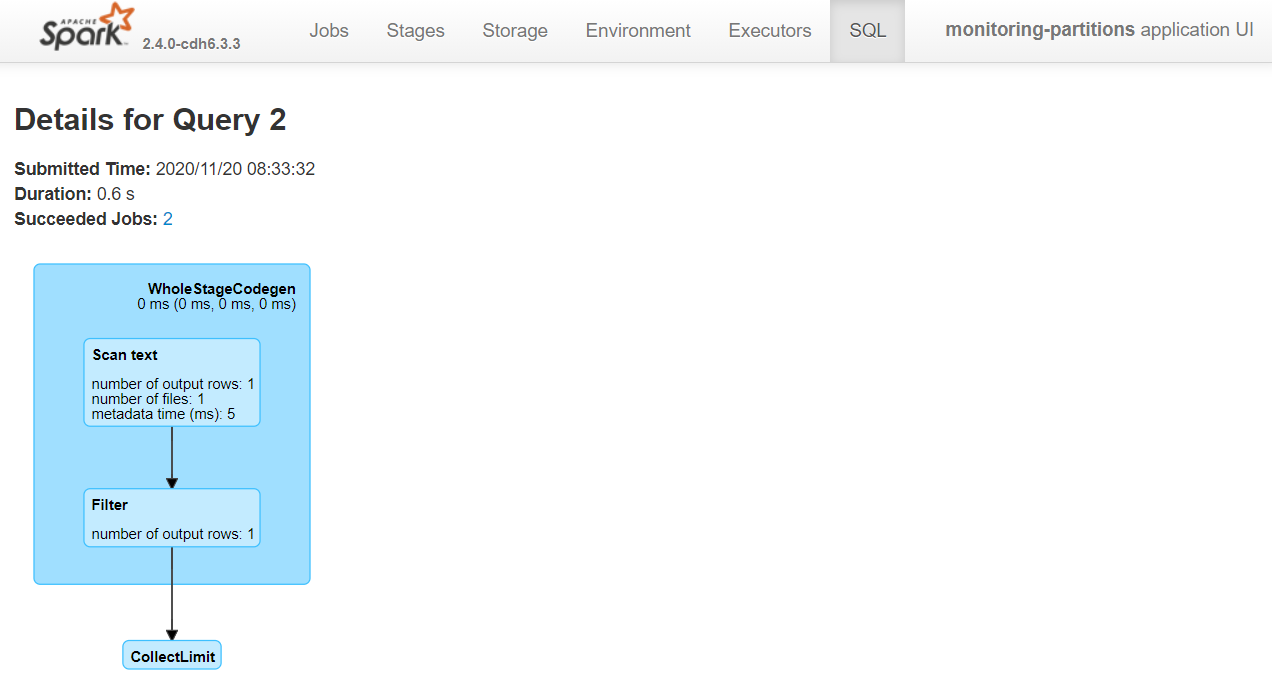

This query is glancing at the `animal_rescue.csv` file to get the schema so that following transformations can be validated before being added to the execution plan (it does this becuase we asked Spark to infer the schema). Doing this for large files can take several minutes, so for large data sets use parquet files or Hive tables, which store the schema for you.

The next three queries (highlighted below) are the functions we have called above. Look at the DAG for each query by clicking on the descriptions, what are your observations?

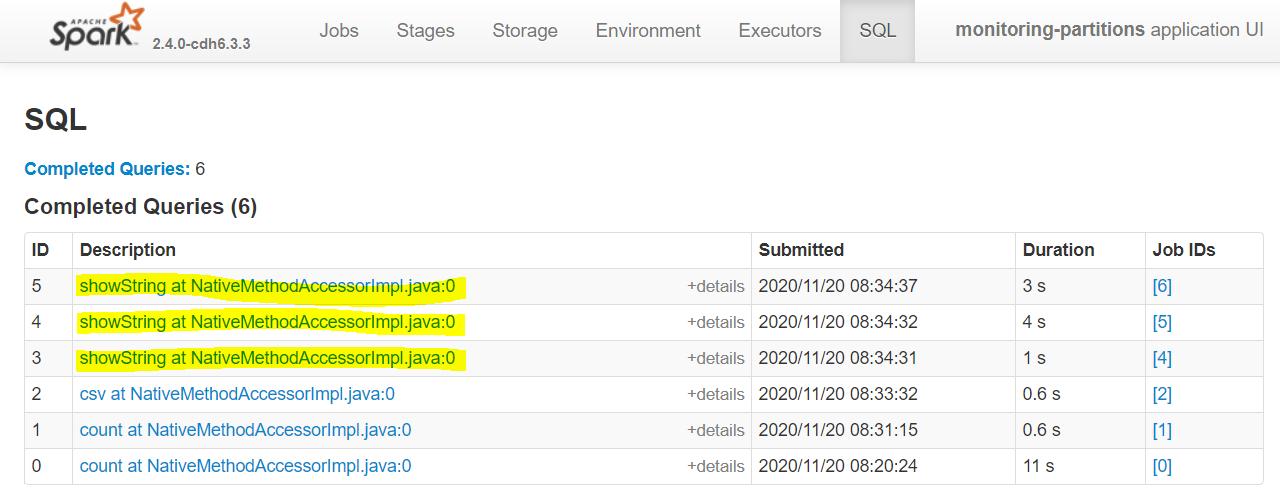
 
**Observations**
- Spark has changed the order of our transformations. We'll look at this later.
- It's difficult to make sense of some boxes!
- Every single one starts with reading in the data (Scan csv).

The last point is a bit odd isn't it? As mentioned earlier, all our preprocessing operations were *transformations*, maybe we need an *action* to update `rescue` before we carry out the analysis functions? Let's try a `.count()` then call one of the functions and look at the DAG for the latest query.

In [54]:
rescue.count()

5860

In [55]:
get_top_10_incidents(rescue).show()

+-------+----------------+--------------------+----------------+---------+
|CalYear|PostcodeDistrict|         AnimalGroup|IncidentDuration|TotalCost|
+-------+----------------+--------------------+----------------+---------+
|   2016|             NW5|                 Cat|             4.0|   3912.0|
|   2013|              E4|               Horse|             6.0|   3480.0|
|   2015|            TN14|               Horse|             5.0|   2980.0|
|   2018|             UB4|               Horse|             4.0|   2664.0|
|   2014|             TW4|                 Cat|             4.5|   2655.0|
|   2011|             E17|               Horse|             3.0|   2340.0|
|   2011|             E14|                Deer|             3.0|   2340.0|
|   2011|             E17|               Horse|             3.0|   2340.0|
|   2018|            TN16|Unknown - Wild An...|             3.5|   2296.0|
|   2017|             N19|                 Cat|             3.5|   2282.0|
+-------+----------------

No! Spark is still reading in the file at the beginning of the query.

## Using `.cache`

What we need to do is to persist the `rescue` DataFrame so when we start our analysis functions Spark will use the persisted DataFrame as the starting point.

Let's `.cache()` the `rescue` DataFrame and do a `.count()` to bring the data into memory.

In [56]:
rescue.cache().count()

5860

In [57]:
get_top_10_incidents(rescue).show()

+-------+----------------+--------------------+----------------+---------+
|CalYear|PostcodeDistrict|         AnimalGroup|IncidentDuration|TotalCost|
+-------+----------------+--------------------+----------------+---------+
|   2016|             NW5|                 Cat|             4.0|   3912.0|
|   2013|              E4|               Horse|             6.0|   3480.0|
|   2015|            TN14|               Horse|             5.0|   2980.0|
|   2018|             UB4|               Horse|             4.0|   2664.0|
|   2014|             TW4|                 Cat|             4.5|   2655.0|
|   2011|             E14|                Deer|             3.0|   2340.0|
|   2011|             E17|               Horse|             3.0|   2340.0|
|   2011|             E17|               Horse|             3.0|   2340.0|
|   2018|            TN16|Unknown - Wild An...|             3.5|   2296.0|
|   2017|             N19|                 Cat|             3.5|   2282.0|
+-------+----------------

In [58]:
get_mean_cost_by_animal(rescue).show()

+--------------------+------------------+
|         AnimalGroup|          MeanCost|
+--------------------+------------------+
|                Goat|            1180.0|
|                Bull|             780.0|
|                Fish|             780.0|
|               Horse| 747.4350649350649|
|Unknown - Animal ...| 709.6666666666666|
|                 Cow| 624.1666666666666|
|            Hedgehog|             520.0|
|                Lamb|             520.0|
|                Deer| 423.8829787234043|
|Unknown - Wild An...|390.03636363636366|
+--------------------+------------------+



In [59]:
get_summary_cost_by_animal(rescue).show()

+-----------+------+-----------------+------+-----+
|AnimalGroup|   Min|             Mean|   Max|Count|
+-----------+------+-----------------+------+-----+
|       Goat|1180.0|           1180.0|1180.0|    1|
|       Fish| 260.0|            780.0|1300.0|    2|
|       Bull| 780.0|            780.0| 780.0|    1|
|      Horse| 255.0|747.4350649350649|3480.0|  154|
+-----------+------+-----------------+------+-----+



Look at the Spark UI. Below is the DAG for the latest query.

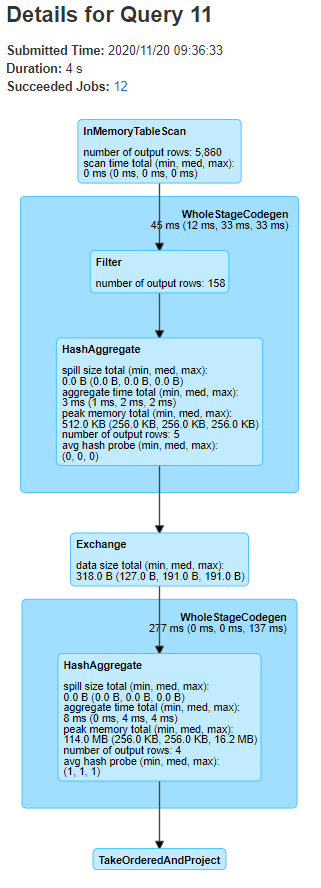

Yay, we don't have to read in the data anymore as our DAG starts with a *InMemoryTableScan*, i.e. cache. Note that this diagram consists of fewer stages than we had previously.

One way of thinking about this is like an old adventure computer game. If you play the game for a while and get to later levels but have to stop playing for some reason, you would want to save where you are so you don't have to start from the beginning next time you play the game. Executing an *action* is like starting the game again. Performing a `.cache()` is like saving where you are in the game.

The "history" of a DataFrame from when it's read into Spark is referred to its *lineage*. Performing a `.cache()` breaks the lineage. There are other methods of breaking the lineage, i.e. `.checkpoint()` or write/read to/from disk, which are sometimes more appropriate. 

In our case, the rescue DataFrame is small and our cleaning was basic so `.cache()` is fine. If we were using a large DataFrame with lots of preprocessing, `.cache()` might not be the best option. In this case we should consider writing the cleaned DataFrame to disk, then have a separate analysis script to read in that clean DataFrame and create the output tables. 

Having a complex process will create a long and complex lineage that can ground processing to a halt so be aware of writing scripts that are hundreds of lines long. 

The main reason we would want to break the lineage here is to speed up the processing. Look at the time taken for each query.

There are many factors that contribute towards the time taken for each query that make benchmarking in Spark complex. When running this notebook, sometimes the processing will be faster after the `.cache()`, but sometimes it will be slower. The point is, it's not significantly faster at the moment.

Run the last three code cells above once more and look at the timings. 

Each function is colour coded in the image below. The first run was without a `.cache()`, the second was with a `.cache()` and the third was a second run with cached data. 

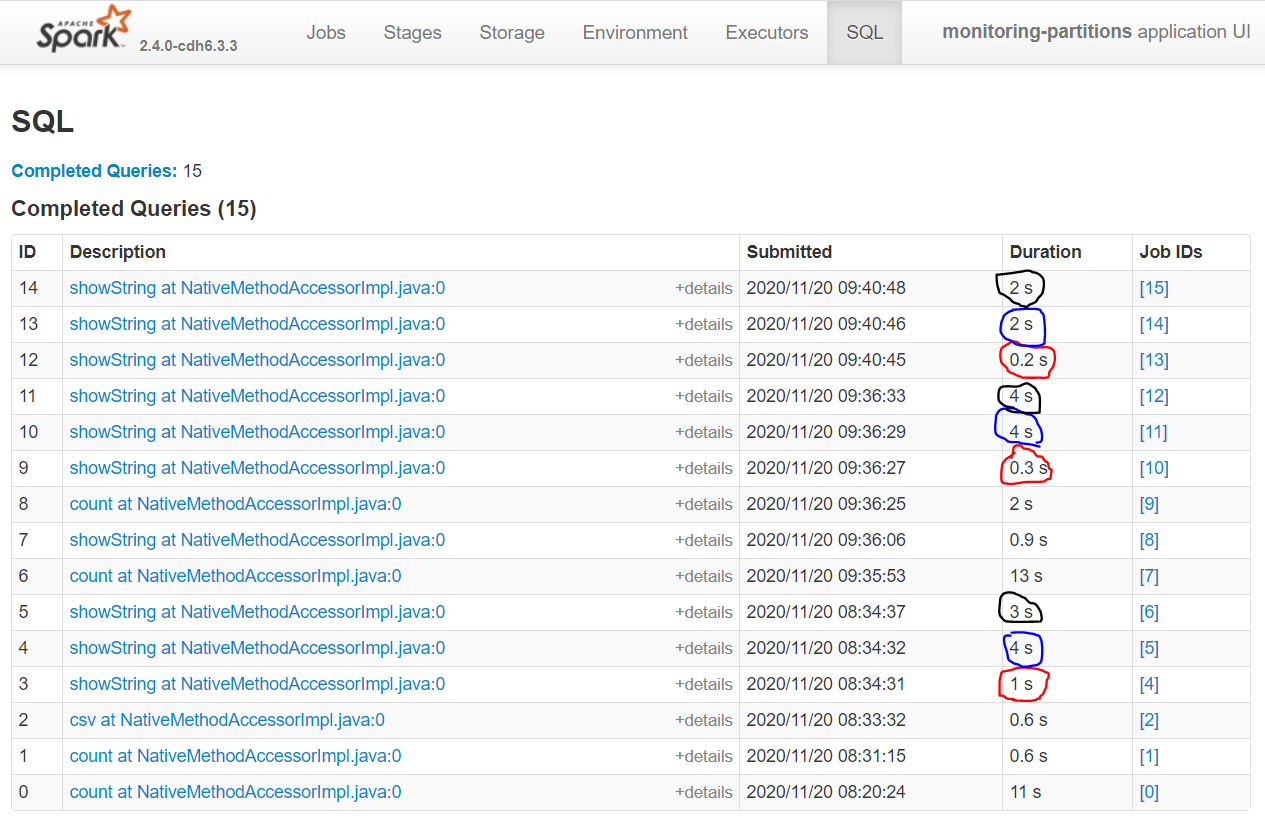

After the first run with cached data we will consistently get faster times.

# Summary

- Spark tracks the lineage (history) of a DataFrame from its origin (often when it's read in from disk)
- Spark will change the order of the execution plan without changing the result. 
    - It does this because it's more efficient to do it Spark's way, e.g. move a filter as early as possible so we're processing less data in the rest of the query. This is done by the **catalyst optimiser**.
- Spark will execute the **whole plan** as opposed to executing the new operations, why? 
    - To allow the catalyst optimiser to work out the best way of executing the job.
- We can get around executing the full plan by **persisting** the data at the appropriate place.
    - Beware, the optimiser is there for a reason and `.cache()` restricts the reach of the optimiser. 
- Caching can increase efficiency by reducing the runtime if used *properly*
    - databricks claim that over 70% or their issue tickets are related to poor use of `.cache()`
    
## When to `.cache`?

- it makes sense to use `.cache()` in the example above because we want to create three new tables from a cleaned data set. However, the processing time is only consistently faster the second time code is run after a `.cache()`. These results will vary depending on the size of the data, type of processing etc..
- a good example is just before running an iterative algorithm, where we make use of the cached DataFrame many times.
- another example is running a model on a DataFrame multiple times trying out different parameters. 
- also, when a DataFrame's lineage is very long, breaking up the lineage by persisting can increase efficiency. There is an alternative that might be more appropriate here, which is `.checkpoint()`, especially when adding 10s or 100s of columns. See the exercises for an example.
- whilst developing your code. For example, perhaps you have just linked two data sets and want to do some checks to make sure the result makes sense. Perhaps the checks would involve running multiple actions (e.g. `.show()`, `.count()`, `.describe()`), but without doing a `.cache()` after the `.join()`, Spark would repeat the join process for each action. Once you're happy with the result you might want to empty the cache and replace `.cache()` with writing the DataFrame to HDFS. 

## When not to `.cache`?

- in an arbitrary manner
- just because someone said it makes your code run faster
- beware when you `.cache()` a large DataFrame without setting the `spark.dynamicAllocation.maxExecutors` config, especially on a small cluster. Spark will assign as many executors as needed to fit the DataFrame in memory, which might be more resource than you intended on using.
- do not over-use `.cache()` in one Spark session. It is worth checking the *Storage* tab in the Spark UI occasionally to make sure there aren't any unwanted caches lying around. Use `spark.catalog.clearCache()` to clear the cache.

Experiment! (...with caution) Try it out and have a look at the SQL DAGs to see what works well for your processing.

# Exercises

1. Updating the `.cache()`

If we change the values in the `rescue` DataFrame will the data in the `.cache()` change also? Try it. Modify the results in the `TotalCost` column, e.g. double the values in this column, and rerun `get_mean_cost_by_animal()` function. Have the numbers changed? Did Spark use the persisted DataFrame? Use the Spark UI to find out.


2. Try `.checkpoint()`

Earlier we mentioned using `.cache()` to simplify the execution plan and break up the lineage of DataFrame that is complex to derive. For a well structured pipeline this isn't often necessary because an intermediate result will be written out to disk after each module. However, sometimes there is no escaping a long execution plan and for a large data set, using `.checkpoint()` will use less executor memory and put less stress on the cluster than using `.cache()`.

`.checkpoint()` is essentially the same as writing the DataFrame to disk and reading it back in again. This will create an intermediate result which can a) be picked up again if anything goes wrong and b) it will start a new execution plan from that point.

Here are some steps to help you,
- clear the cache using `spark.catalog.clearCache()` just to make absolutely sure Spark uses the checkpoint as opposed to the `.cache()`
- set up a checkpoint location somewhere on HDFS, e.g. `spark.sparkContext.setCheckpointDir('/user/<your_username>/checkpoints/')`
- create a checkpoint copy e.g. `rescue_checkpoint = rescue.checkpoint()` 
- run the analysis functions again on the checkpoint copy

How does Spark show the checkpoint in the DAG for these queries? Using HUE take a look to see where the checkpoint is stored. Make sure you delete unwanted checkpoints, the easiest way to do it is by deleting the files on HUE, but it can be handy to write some code to do this automatically at the end of a script that uses checkpoints. Have a go!

<span style="color:blue">For R users, you can set the checkpoint directory using,</span>

`spark_set_checkpoint_dir(sc, '/user/<your_username>/checkpoints/')`

<span style="color:blue">Then to checkpoint a DataFrame `sdf` you can use,</span>

`sdf_checkpoint(sdf2, eager=TRUE)`

<span style="color:blue">The `eager=TRUE` argument is an option of truncating the lineage of the DataFrame.</span>



3. The catalyst optimiser 

It's possible to see the execution plan for a DataFrame either by 
    a) going into the SQL tab on the Spark UI, click on a query and open the 'Details' collapsable menu, or
    b) use `.explain(True)` on a DataFrame, or `.explain()` for the short version.

Each heading of the *full* execution plan represents a stage of the optimiser, as shown in the diagram [on this databricks page](https://databricks.com/glossary/catalyst-optimizer). To read the execution plan you must start at the bottom of a section at the **most indented** line, then move up to the next-most indented line and so on. 

The *Parsed Logical Plan* will show the order in which the query was written, then we have the *Analysed Logial Plan*, *Optimised Logical Plan* and finally the *Physical Plan*, which is what Spark actually executes and is represented in the SQL DAG diagrams.

Try to follow the *Parsed Logical Plan* alongside the code we used to prepare `rescue` before doing our analysis. Then compare the *Physical Plan* with the same code. Can you understand *why* Spark changed the order of the transformations? What does this tell you about the order 

<span style="color:blue">For R users, to get the explain plan you just need to pipe your DataFrame into `explain()`</span>

In [60]:
# Solution 1

# Run the function to have answers at hand to compare
print("Before doubling TotalCost values")
get_mean_cost_by_animal(rescue).show()

# Double TotalCost
rescue = rescue.withColumn("TotalCost", F.col("TotalCost") * 2)

# Rerun the function to get new results
print("After doubling TotalCost values")
get_mean_cost_by_animal(rescue).show()

# It looks like the results are as expected. What about how Spark got to this result?
# Did Spark update the cached data after the new transformation?

# Looking at the DAG for the most recent query we see that Spark did the following:
# 1. Take the cached data (InMemoryTableScan)
# 2. Apply the transformation (hover over the first Project to see TotalCost * 2)
# 3. Apply the groupby, sort and limit within the get_mean_cost_by_animal() function

# Therefore Spark did not update the cache, but it did start the query from the cache.

Before doubling TotalCost values
+--------------------+------------------+
|         AnimalGroup|          MeanCost|
+--------------------+------------------+
|                Goat|            1180.0|
|                Bull|             780.0|
|                Fish|             780.0|
|               Horse| 747.4350649350649|
|Unknown - Animal ...| 709.6666666666666|
|                 Cow| 624.1666666666666|
|            Hedgehog|             520.0|
|                Lamb|             520.0|
|                Deer| 423.8829787234043|
|Unknown - Wild An...|390.03636363636366|
+--------------------+------------------+

After doubling TotalCost values
+--------------------+------------------+
|         AnimalGroup|          MeanCost|
+--------------------+------------------+
|                Goat|            2360.0|
|                Bull|            1560.0|
|                Fish|            1560.0|
|               Horse|1494.8701298701299|
|Unknown - Animal ...|1419.3333333333333|
|         

In [61]:
# Solution 2

# Clear cache
spark.catalog.clearCache() #worth checking Storage tab in UI to make sure it's clear

import os
username = os.getenv("HADOOP_USER_NAME")
data_path = f"/user/{username}/more_spark"

#Set checkpoint directory within own area on HDFS
checkpoint_dir = data_path + "/checkpoints/persist_notebook"
spark.sparkContext.setCheckpointDir(checkpoint_dir)

# Store checkpoint
rescue_checkpoint = rescue.checkpoint()

# Rerun analysis functions
get_top_10_incidents(rescue_checkpoint).show()
get_mean_cost_by_animal(rescue_checkpoint).show()
get_summary_cost_by_animal(rescue_checkpoint).show()

# Look at DAGs for latest queries. The query starts with Scan ExistingRDD, which is the
# checkpointed DataFrame. The time difference in using .cache() and .checkpoint() here
# isn't significant. But it's worth considering both in your own work.

# Delete checkpoint
import subprocess
cmd = f'hdfs dfs -rm -r -skipTrash {checkpoint_dir}' 
p = subprocess.run(cmd, shell=True)

+-------+----------------+--------------------+----------------+---------+
|CalYear|PostcodeDistrict|         AnimalGroup|IncidentDuration|TotalCost|
+-------+----------------+--------------------+----------------+---------+
|   2016|             NW5|                 Cat|             4.0|   7824.0|
|   2013|              E4|               Horse|             6.0|   6960.0|
|   2015|            TN14|               Horse|             5.0|   5960.0|
|   2018|             UB4|               Horse|             4.0|   5328.0|
|   2014|             TW4|                 Cat|             4.5|   5310.0|
|   2011|             E14|                Deer|             3.0|   4680.0|
|   2011|             E17|               Horse|             3.0|   4680.0|
|   2011|             E17|               Horse|             3.0|   4680.0|
|   2018|            TN16|Unknown - Wild An...|             3.5|   4592.0|
|   2017|             N19|                 Cat|             3.5|   4564.0|
+-------+----------------

In [62]:
# Solution 3

# Note these answers were obtained after running the notebook all the way through including solutions to 1 and 2.

# Get the full plan for the rescue DataFrame
rescue.explain(True)

# Reading from the bottom of the == Parsed Logical Plan ==:
# +- Relation > reading in the csv file
#  +- Repartition 2 > repartition the DataFrame
#   +- Project > drop some columns (the list of columns is shorter than previously)
#    +- The next 7 Projects > rename 7 columns (note the SQL syntax e.g. PumpCount AS EngineCount)
#     +- Project > change format of DateTimeOfCall column (to_date(DateTimeOfCall, Some(dd/MM/yyyy)) AS DateTimeOfCall)
#      +- Project > add the InicidentDuration column ((JobHours / EngineCount) AS IncidentDuration)
#       +- Filter > drop nulls in TotalCost and IncidentDuration

# Looking at the == Physical Plan ==:
# +- FileScan > quick look at file to determine schema
#  +- Filter > drop nulls
#   +- Exchange > this means a shuffle, which was incured by the repartition
#    +- Project > drop columns, rename 7 columns, change format of DateTimeOfCall, add new column (all in one step)

# Things to note:
# - Fewer steps. The Projects from the Parsed Logical Plan were condensed into one.
# - Change of order. The catalyst optimiser moved the filter as early as possible to process less data later.

# Although Spark changes the order for us, it's good practice when using big data to move filters early on in processing.

== Parsed Logical Plan ==
'Project [IncidentNumber#1855, DateTimeOfCall#2074, CalYear#1857, FinYear#1858, TypeOfIncident#1859, EngineCount#1927, JobHours#2032, HourlyCost#1969, ('TotalCost * 2) AS TotalCost#3156, Description#1948, AnimalGroup#2053, OriginOfCall#2011, PropertyType#1867, PropertyCategory#1868, SpecialServiceTypeCategory#1869, SpecialServiceType#1870, Ward#1872, Borough#1874, StnGroundName#1875, PostcodeDistrict#1876, IncidentDuration#2095]
+- Filter AtLeastNNulls(n, TotalCost#1990,IncidentDuration#2095)
   +- Project [IncidentNumber#1855, DateTimeOfCall#2074, CalYear#1857, FinYear#1858, TypeOfIncident#1859, EngineCount#1927, JobHours#2032, HourlyCost#1969, TotalCost#1990, Description#1948, AnimalGroup#2053, OriginOfCall#2011, PropertyType#1867, PropertyCategory#1868, SpecialServiceTypeCategory#1869, SpecialServiceType#1870, Ward#1872, Borough#1874, StnGroundName#1875, PostcodeDistrict#1876, (JobHours#2032 / EngineCount#1927) AS IncidentDuration#2095]
      +- Project [In